In [1]:
%matplotlib inline

In [2]:
import math as math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

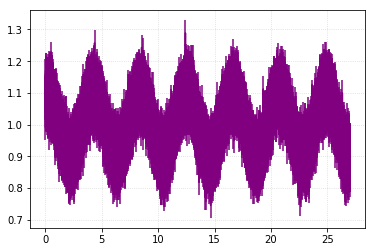

In [3]:
#Plot flux vs time with error bars
worksheet2data = pd.read_csv('worksheet2.txt', sep=" ", header=None)
worksheet2data.columns = ["time", "flux", "error"]
time, flux, err = np.loadtxt("worksheet2.txt").T
x = worksheet2data['time']
y = worksheet2data['flux']
yerr = worksheet2data['error']
fig, ax = plt.subplots()
ax.errorbar(x, y, yerr, solid_capstyle='projecting', color='purple')
ax.grid(alpha=0.5, linestyle=':')
plt.show()

In [4]:
def model(period, phase, time):
    return(1 + 0.1 * np.sin(2 * np.pi * period * time + phase))

%%time

#I got this message at one point: IOPub data rate exceeded. The notebook server will temporarily stop sending output to the client in order to avoid crashing it.
#How can I speed this up?

periods = np.random.random_sample(100) * 8
phases = np.random.random_sample(100) * 2*math.pi

t = worksheet2data['time'].values
f = worksheet2data['flux'].values

chisq = np.empty((len(periods), len(phases)))
for p in range(100):
    for h in range(100):
        m = model(periods[p], phases[h], t)
        diff_sq = np.square(m - f)
        chisq[p, h] = diff_sq.sum()
print(chisq)

In [12]:
%%time
periods = np.linspace(2, 6, 100)
phases = np.linspace(0, 2 * np.pi, 100).reshape(-1,1)
chisq = np.empty((len(periods), len(phases)))

#model(periods, phases, time)
#chisq[i, j] = 
#for i, period in enumerate(periods):
    #for j, phase in enumerate(phases):
        #chisq[i, j] = np.sum((model(period, phase, time) - flux) ** 2)

for i, period in enumerate(periods):
    chisq[i] = np.sum((model(period, phases, time) - flux) ** 2)

CPU times: user 7.13 s, sys: 1.55 s, total: 8.68 s
Wall time: 8.72 s


In [22]:
#broadcasting

#x = np.linspace(0, 10, 11)
#print(x)
#print(x.shape)
#print(x.reshape(11,1))
#print(x.reshape(11,1).shape)

#y = np.array([1, 2, 3])
#print(y)
#print(y.shape)
#print(x.reshape(-1,1) * y)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
(11,)
[[  0.]
 [  1.]
 [  2.]
 [  3.]
 [  4.]
 [  5.]
 [  6.]
 [  7.]
 [  8.]
 [  9.]
 [ 10.]]
(11, 1)


In [ ]:
extent = (phases.min(), phases.max(), periods.min(), periods.max())
best_i, best_j = np.unravel_index(np.argmin(chisq, axis=None), chisq.shape)
best_period = periods[best_i]
best_phase = phases[best_j]
plt.axvline(best_phase, color="k")
plt.axhline(best_period, color="k")
plt.title("$P$ = {:.3f} days ; $\phi$ = {:.3f} radians".format(best_period, best_phase))
plt.imshow(chisq, origin="lower", extent=extent)
plt.colorbar(label=r"$\chi^2$")
plt.xlabel("Phase [radians]")
plt.ylabel("Period [days]");

In [ ]:
likelihood = np.exp(-0.5 * (chisq - chisq.min()))
plt.imshow(likelihood, origin="lower", extent=extent, aspect='auto')
plt.colorbar(label=r"Likelihood")
plt.xlabel("Phase [radians]")
plt.ylabel("Period [days]");
plt.axvline(best_phase, color="k")
plt.axhline(best_period, color="k")
plt.xlim(1.0, 1.7)
plt.ylim(4.05, 4.18);

In [ ]:
def Gaussian(x, mu, sigma):
    return np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))

like_phases = np.sum(likelihood, axis=0)
like_phases /= np.max(like_phases)

coeff, _ = curve_fit(Gaussian, phases, like_phases, p0=[best_phase, 0.1])
mu_phase, sigma_phase = coeff

plt.plot(phases, like_phases, label="Marginal likelihood")
plt.plot(phases, Gaussian(phases, mu_phase, sigma_phase), label="Gaussian fit")
plt.xlim(0.7, 2.0);
plt.legend()
plt.xlabel("Period [days]")
plt.ylabel(r"Relative Likelihood");
plt.title("$\phi = {:.3f} \pm {:.4f}$ radians".format(mu_phase, sigma_phase));

In [ ]:
like_periods = np.sum(likelihood, axis=1)
like_periods /= np.max(like_periods)

coeff, _ = curve_fit(Gaussian, periods, like_periods, p0=[best_period, 0.1])
mu_period, sigma_period = coeff

plt.plot(periods, like_periods, label="Marginal likelihood")
plt.plot(periods, Gaussian(periods, mu_period, sigma_period), label="Gaussian fit")
plt.xlim(4, 4.25);
plt.legend()
plt.xlabel("Period [days]")
plt.ylabel(r"Relative Likelihood");
plt.title("$P = {:.3f} \pm {:.4f}$ days".format(mu_period, sigma_period));

In [ ]:
plt.plot(time, flux, 'k.', ms=2, alpha=0.3, label="data", zorder=-1)
plt.plot(time, model(mu_period, mu_phase, time), label="model")
plt.xlabel("Time [days]")
plt.legend(numpoints=5)
plt.ylabel("Flux");